<a href="https://colab.research.google.com/github/TonioFlag/ProyectoFinalColas/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pingouin
!pip install distfit

In [307]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pingouin as pg
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from distfit import distfit

In [3]:
arribo=pd.read_excel('/content/drive/MyDrive/Actual/COLAS/Tasas de arribo.xlsx')

num=[]
for i in arribo['dia']:
  if i=="Lunes":
    num.append(1)
  elif i=="Martes":
    num.append(2)
  elif i=="Miercoles":
    num.append(3)
  elif i=="Jueves":
    num.append(4)
  elif i=="Sabado":
    num.append(6)
  elif i=="Viernes":
    num.append(5)
  elif i=="Domingo":
    num.append(7)

arribo['num_dia']=num

intervalos=5
amplitud=arribo.min_cliente.max()-arribo.min_cliente.min()
intervalo=amplitud/5
clasificacion=[]
for i in arribo.min_cliente:
  if i <= intervalo: clasificacion.append(1)
  elif i <= 2*intervalo: clasificacion.append(2)
  elif i <= 3*intervalo: clasificacion.append(3)
  elif i <= 4*intervalo: clasificacion.append(4)
  elif i <= 5*intervalo: clasificacion.append(5)

arribo['clase']=clasificacion


arribo['Llegada']=pd.to_datetime(arribo['Llegada'],format='%H:%M:%S')

intervalos = [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22)]
es=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

def asignar_intervalo(hora):
    for i in range(len(intervalos)):
        if intervalos[i][0] <= hora.hour < intervalos[i][1]:
            return es[i]

arribo['intervalo'] = arribo['Llegada'].apply(asignar_intervalo)


In [169]:
meses_dict = {'Abril': 4, 'Septiembre': 9,'Noviembre': 11}
arribo['num_mes'] = arribo['Mes'].map(meses_dict)
servicios=list(arribo['TipoServ.'].unique())
servicio = {servicios[0]: 1, servicios[1]: 2,servicios[2]: 3,servicios[3]: 4,servicios[4]: 5}
arribo['tipo_serv'] = arribo['TipoServ.'].map(servicio)

#Hallando los kmeans, para determinar agrupamientos, se descubre que para el turno 1 se puede representar en 5 grupos y el turno 2, no arroja nada relevante

In [177]:
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]

for t in [1,2]:
  base=arribo[(arribo['Turno']==t)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  df=pd.DataFrame()

  for k in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    df[k] = kmeans.labels_
  cosas=["Mes","dia","TipoServ.","intervalo","Cuadrilla"]

  for k in list(df.columns):
    base['kmeans']=df[k]

    for i in base['kmeans'].unique():
      eval=base[(base['kmeans']==i)]

      for j in cosas:
        if len(eval[j].unique())>1:
          mete=(k,i)
          sorce.append(j)
          turno.append(t)
          arreglo.append(mete)
          kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
          levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
          pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
result=[]
for i in kruskal['p-unc']:
  if i<=5e-02:
    result.append(False)
  else:
    result.append(True)
kruskal["Independencia"]=result
levene['Source']=sorce


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [178]:
for t in [1,2]:
  print("**"*10)
  print("Para el turno "+str(t))
  for i in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("%%%"*10)
    print("Para grupos de "+str(i))
    print("--"*10)
    print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)&(kruskal['turno']==t)])
    print("++"*10)
    print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)&(levene['turno']==t)])
    print("--"*10)

********************
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1          H     p-unc   grupo  turno  Independencia
Kruskal        Mes      2   8.616003  0.013460  (2, 0)      1          False
Kruskal  intervalo      8  16.687837  0.033529  (2, 0)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  5.548208  7.984354e-07      False  (2, 0)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
            Source  ddof1          H     p-unc   grupo  turno  Independencia
Kruskal  intervalo      7  19.860731  0.005878  (3, 1)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  2.714438  3.033439e-02      False  (3, 1)      1  TipoServ.
levene  7.532508  2.731065e-08      False  (3, 1)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%

In [302]:
def dispercion(tur,n_kluster):
  base=arribo[(arribo['Turno']==tur)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=n_kluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  plt.figure(figsize=(8, 6))

    # Iterar sobre los clústeres y visualizar la dispersión
  for evaluando in base['kmeans'].unique():
    cluster_data = base[base['kmeans'] == evaluando]
    x = len(cluster_data) - 1
    plt.scatter(cluster_data['min_cliente'][:x],
                cluster_data['min_cliente'][1:],
                label=f'Cluster {evaluando}',
                s=8,
                alpha=0.7)

    # Configurar etiquetas y leyenda
  plt.xlabel("Tiempo de llegada (Xi)")
  plt.ylabel("Tiempo de llegada siguiente (Xi+1)")
  plt.title(f"Scatter plot de tiempos de arribo - Turno {tur}")
  plt.legend(title="Cluster")

    # Mostrar el gráfico
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


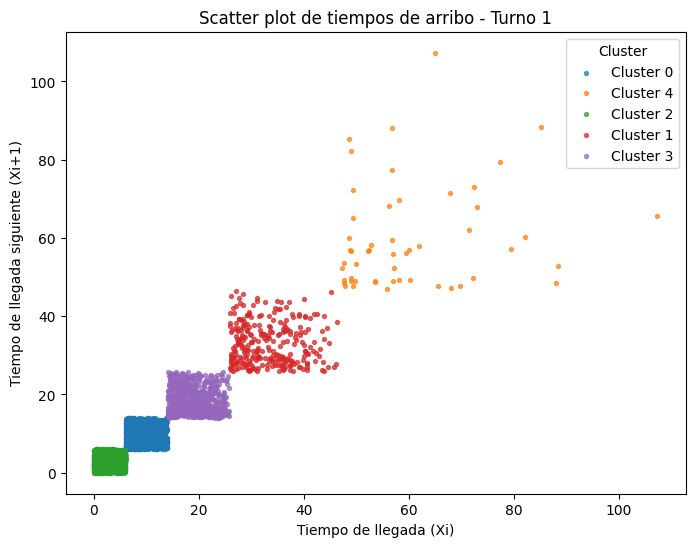

In [305]:
dispercion(1,5)

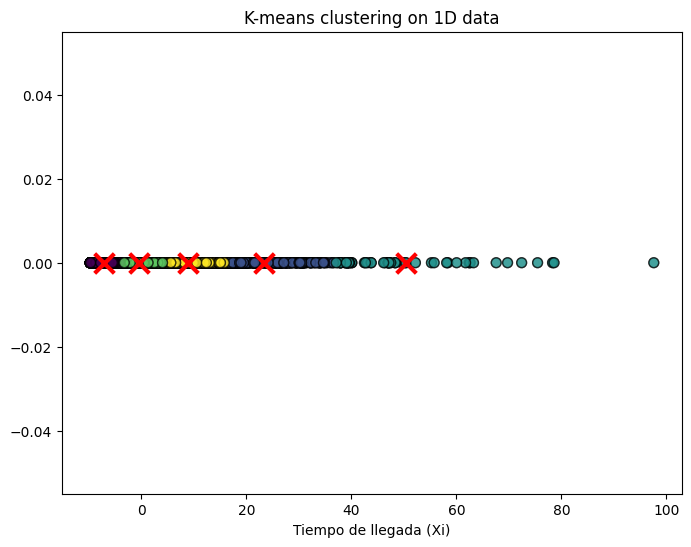

In [256]:
import matplotlib.pyplot as plt

x=range(len(base['min_cliente'])-1)
par=[]
for i in x:
  mete=(base['min_cliente'].iloc[i],base['min_cliente'].iloc[i+1])
  par.append(mete)
X=np.array(par).reshape(-1,1)

reduced_data = PCA(n_components=1).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=5, n_init=4)
kmeans.fit(reduced_data)

reduced_data = PCA(n_components=1).fit_transform(X)

# Aplicar K-means
kmeans = KMeans(init="k-means++", n_clusters=5, n_init=4)
kmeans.fit(reduced_data)

# Visualización
# Visualización
plt.figure(figsize=(8, 6))

# Scatter plot de los datos originales
plt.scatter(reduced_data, np.zeros_like(reduced_data), c=kmeans.labels_, cmap='viridis', s=50, edgecolors='k', alpha=0.6)

# Scatter plot de los centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids, np.zeros_like(centroids), marker="x", s=200, linewidths=3, color="r", zorder=10)

plt.title("K-means clustering on 1D data")
plt.xlabel("Tiempo de llegada (Xi)")
plt.show()

##Sacando las fit


In [311]:
def fit(turno,ncluster):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  for i in base['kmeans'].unique():

    dfit = distfit()
    results2 = dfit.fit_transform(base[(base['kmeans']==i)]['min_cliente'])
    results2['summary'].to_excel("grupo_"+str(i)+".xlsx")

    dfit.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0269173] [loc=9.444 scale=2.242]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0248178] [loc=6.050 scale=3.394]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0248178] [loc=-268435449.950 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.0361251] [loc=9.655 scale=2.134]
[distfit] >INFO> [t         ] [0.68 sec] [RSS: 0.0269183] [loc=9.444 scale=2.242]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.0227742] [loc=8.519 scale=2.007]
[distfit] >INFO> [gamma     ] [0.09 sec] [RSS: 0.015343] [loc=5.811 scale=1.846]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0209869] [loc=2.497 scale=6.584]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 0.00137391] [loc=6.050 scale=7.998]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0128562] [loc=6.050 scale=7.967]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 0.0264912] [loc=-664.731 scale=91.234]
[distfit] >INFO> fit
[distfit

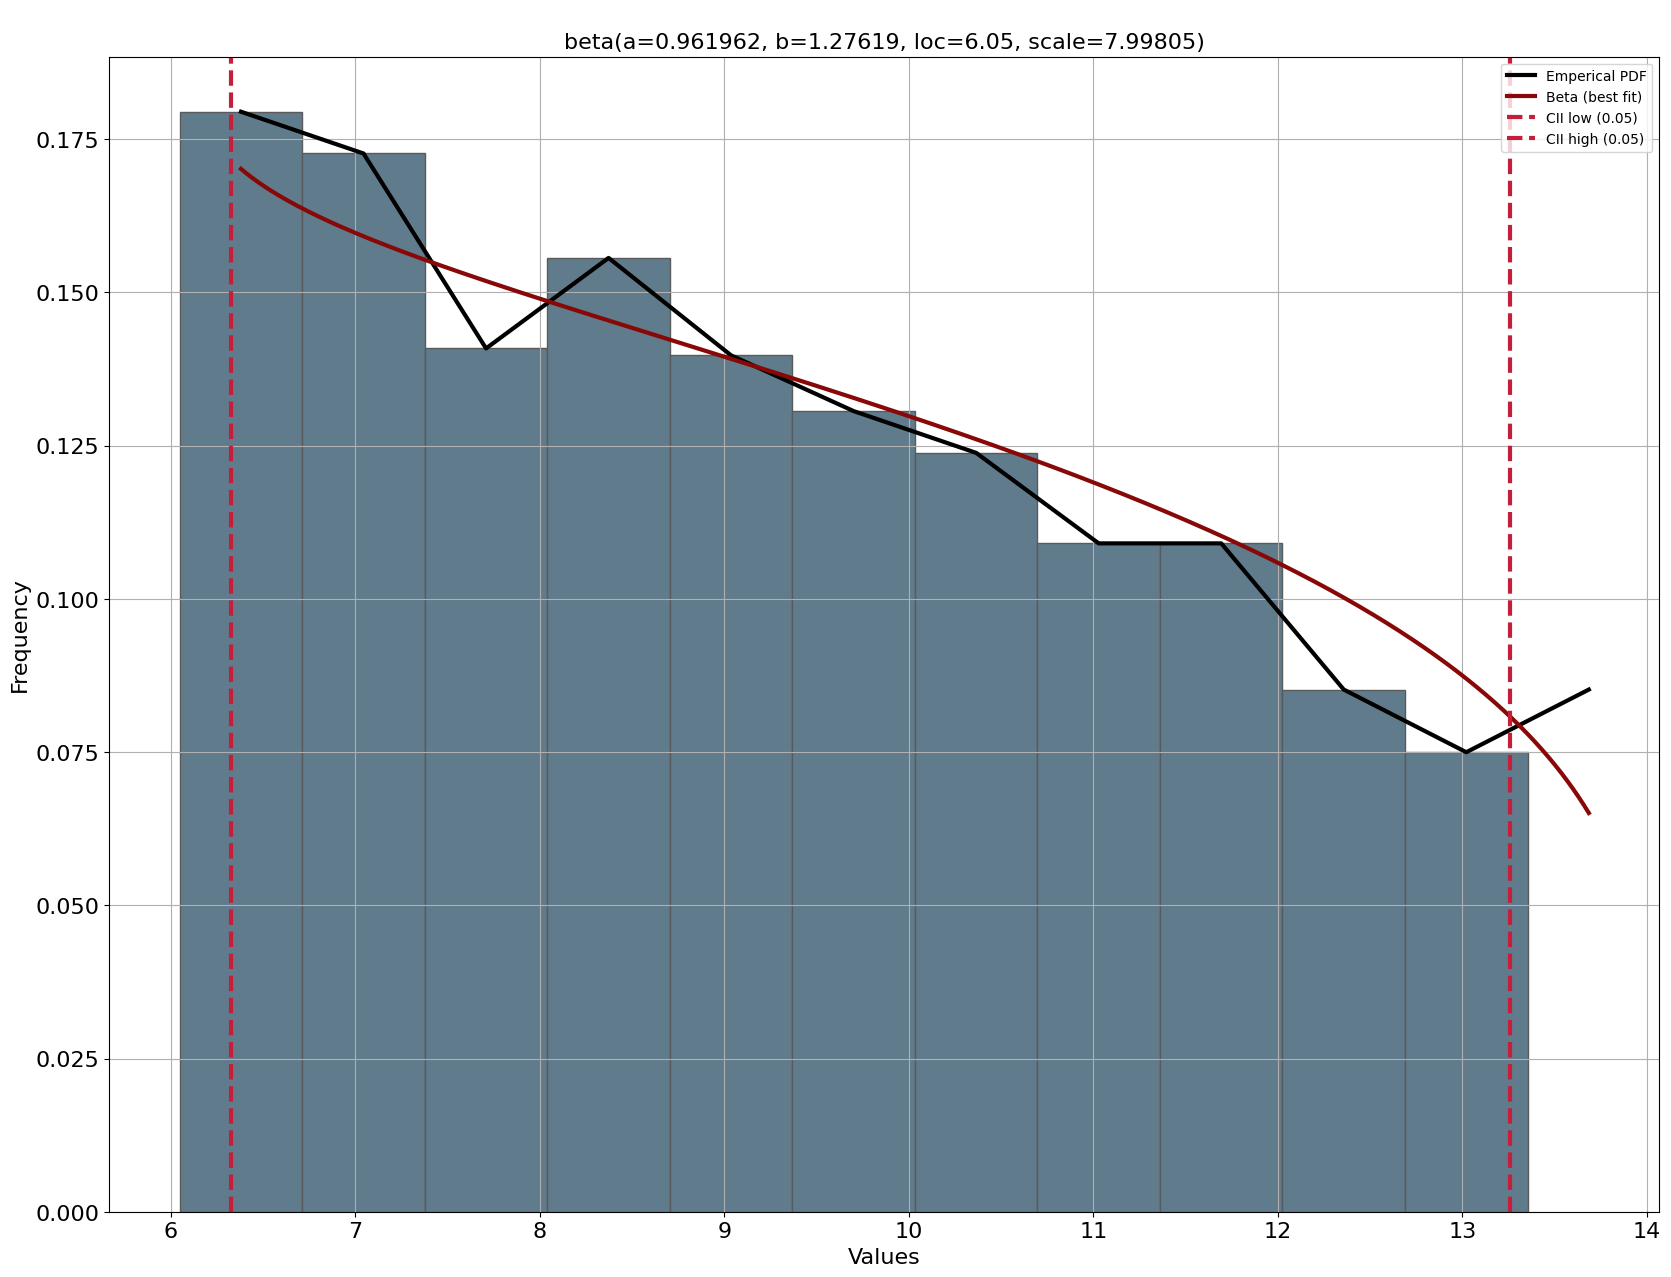

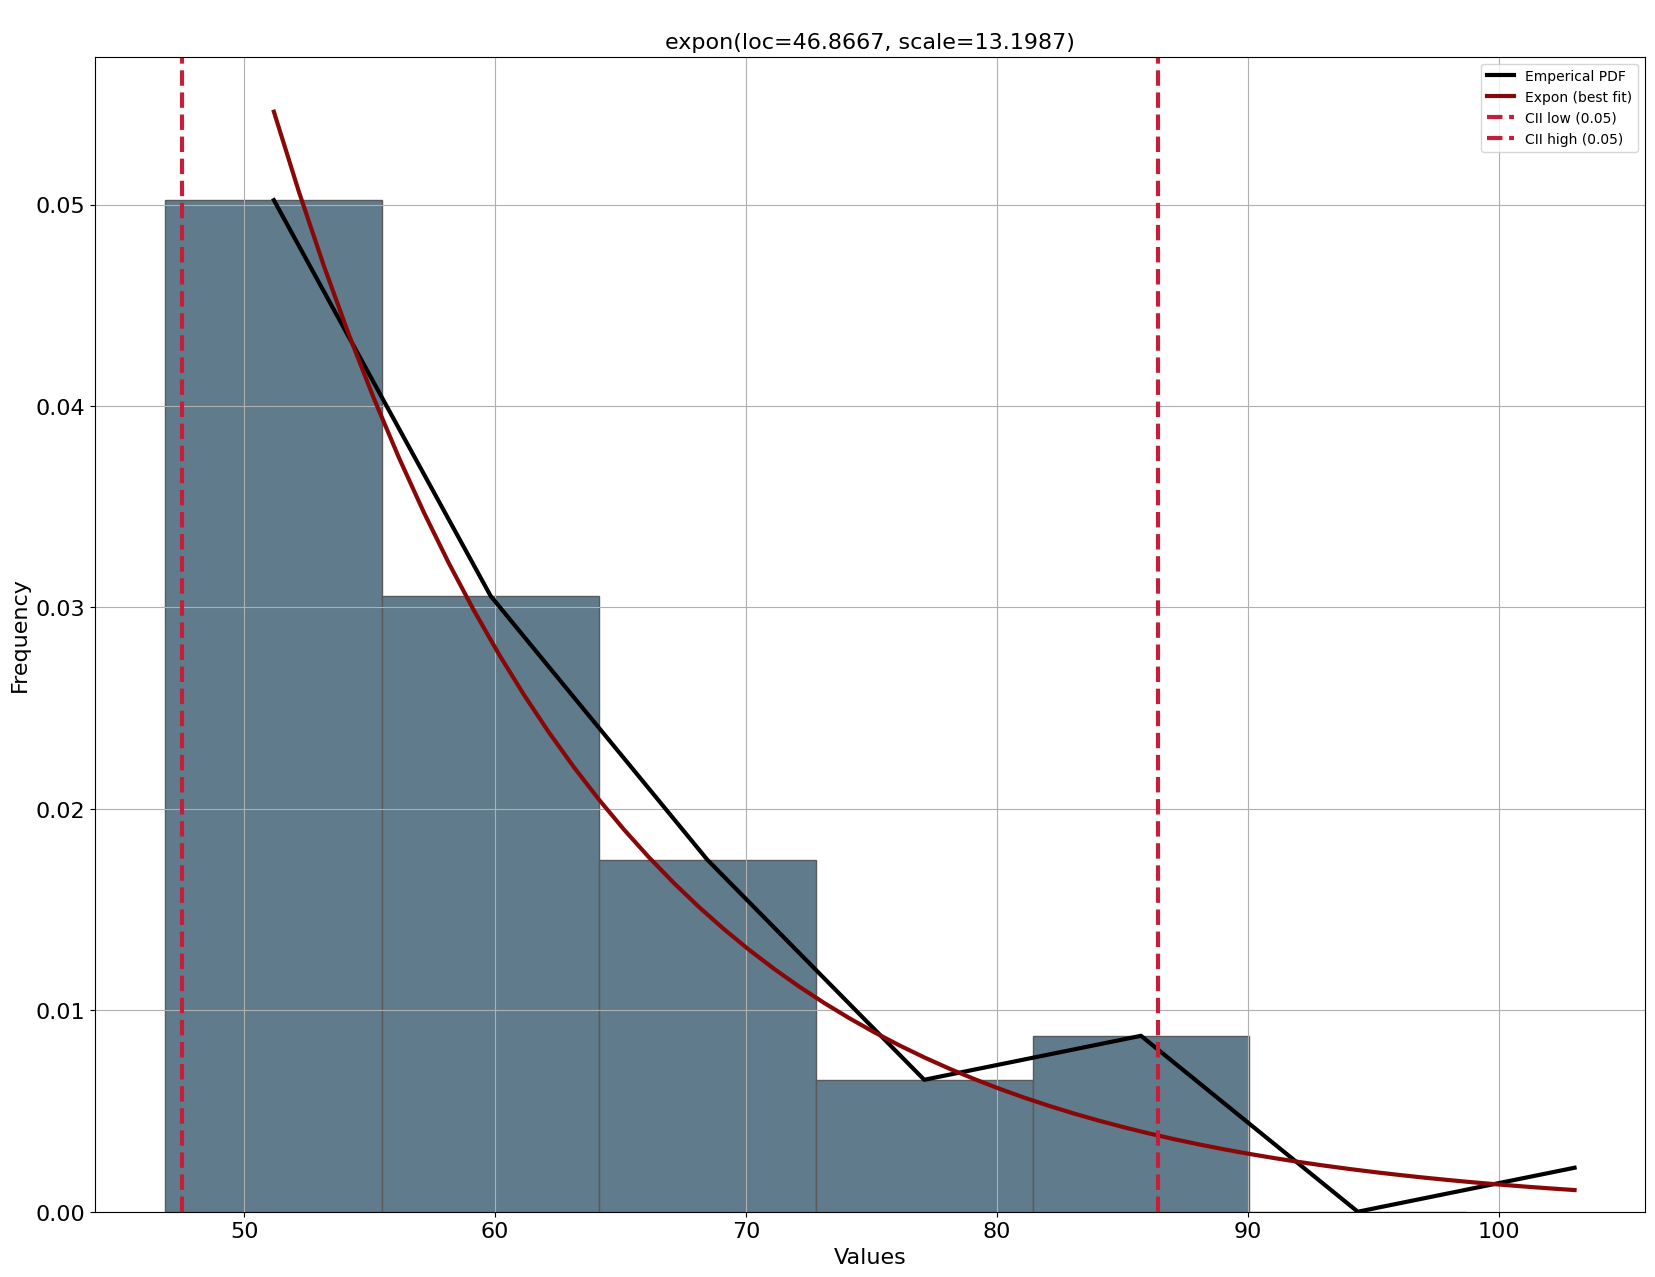

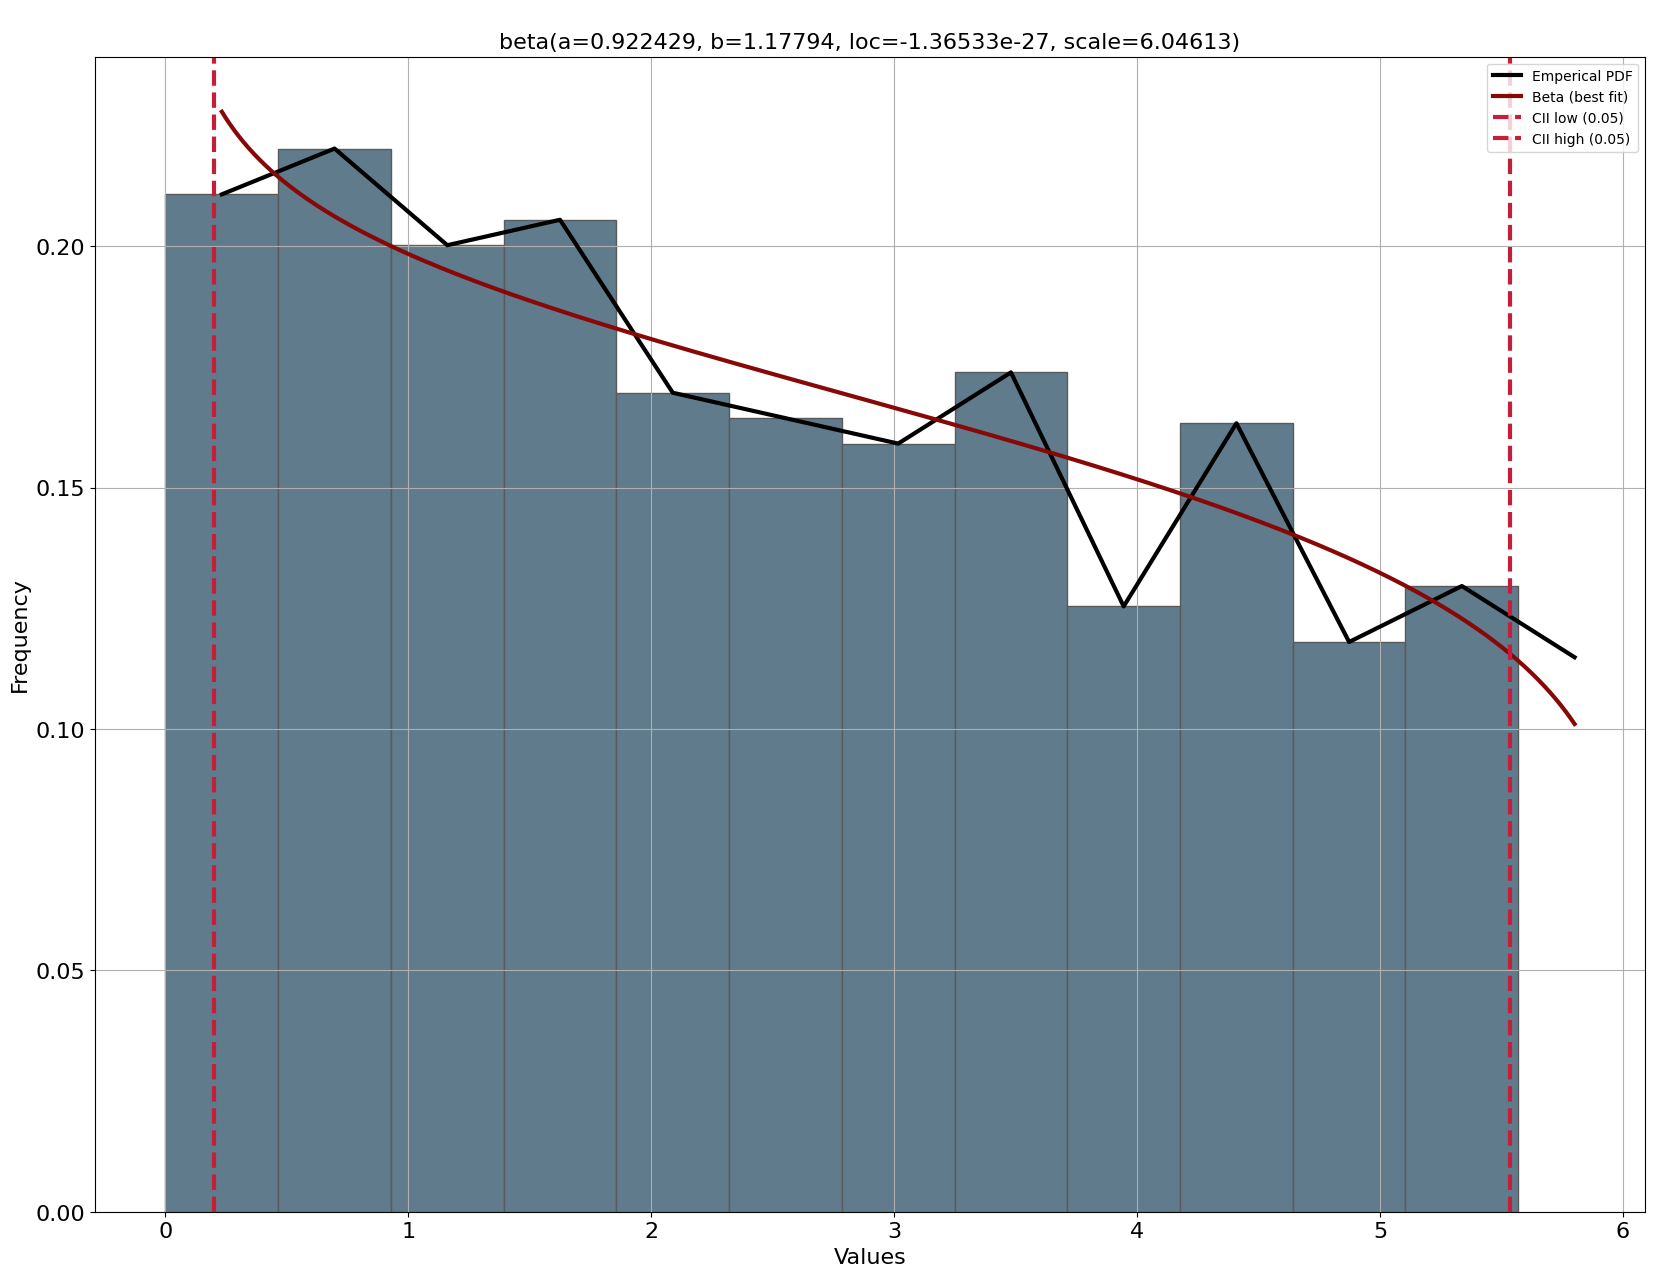

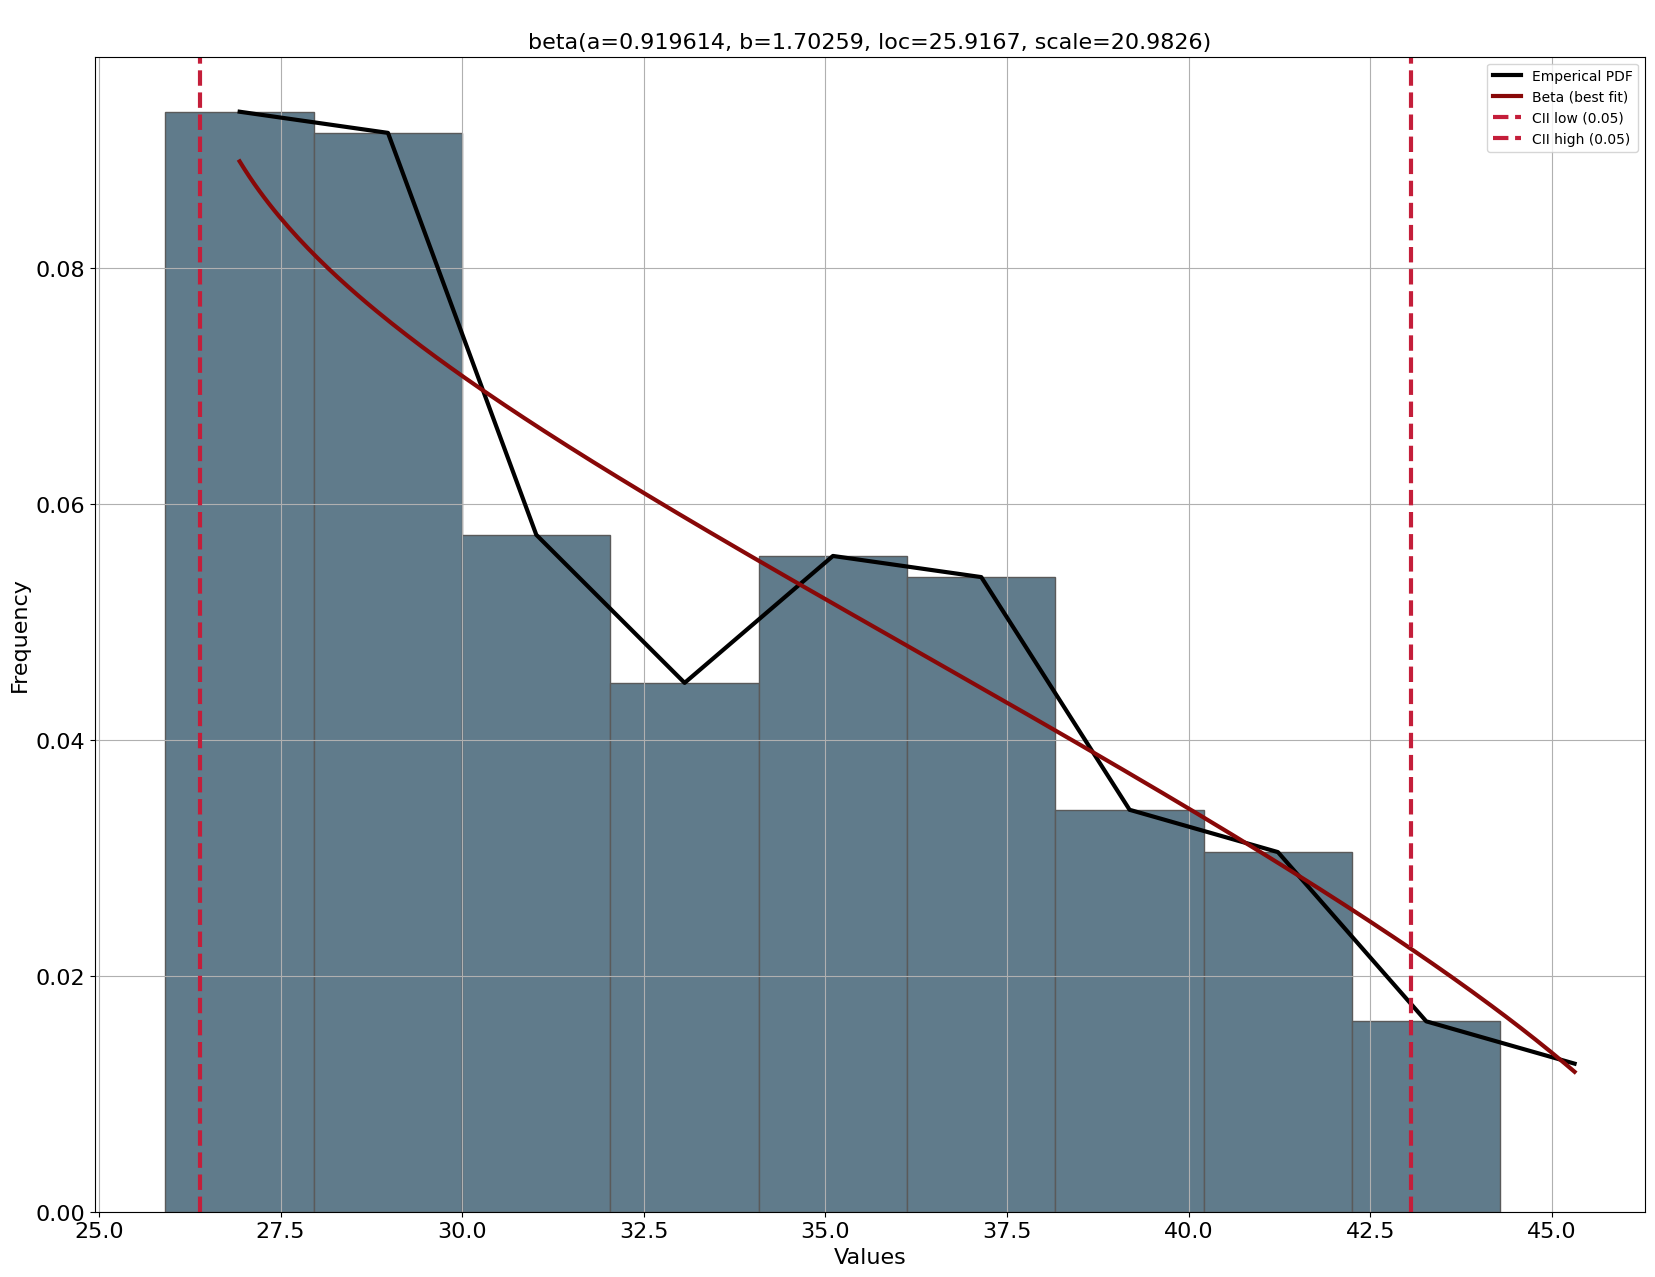

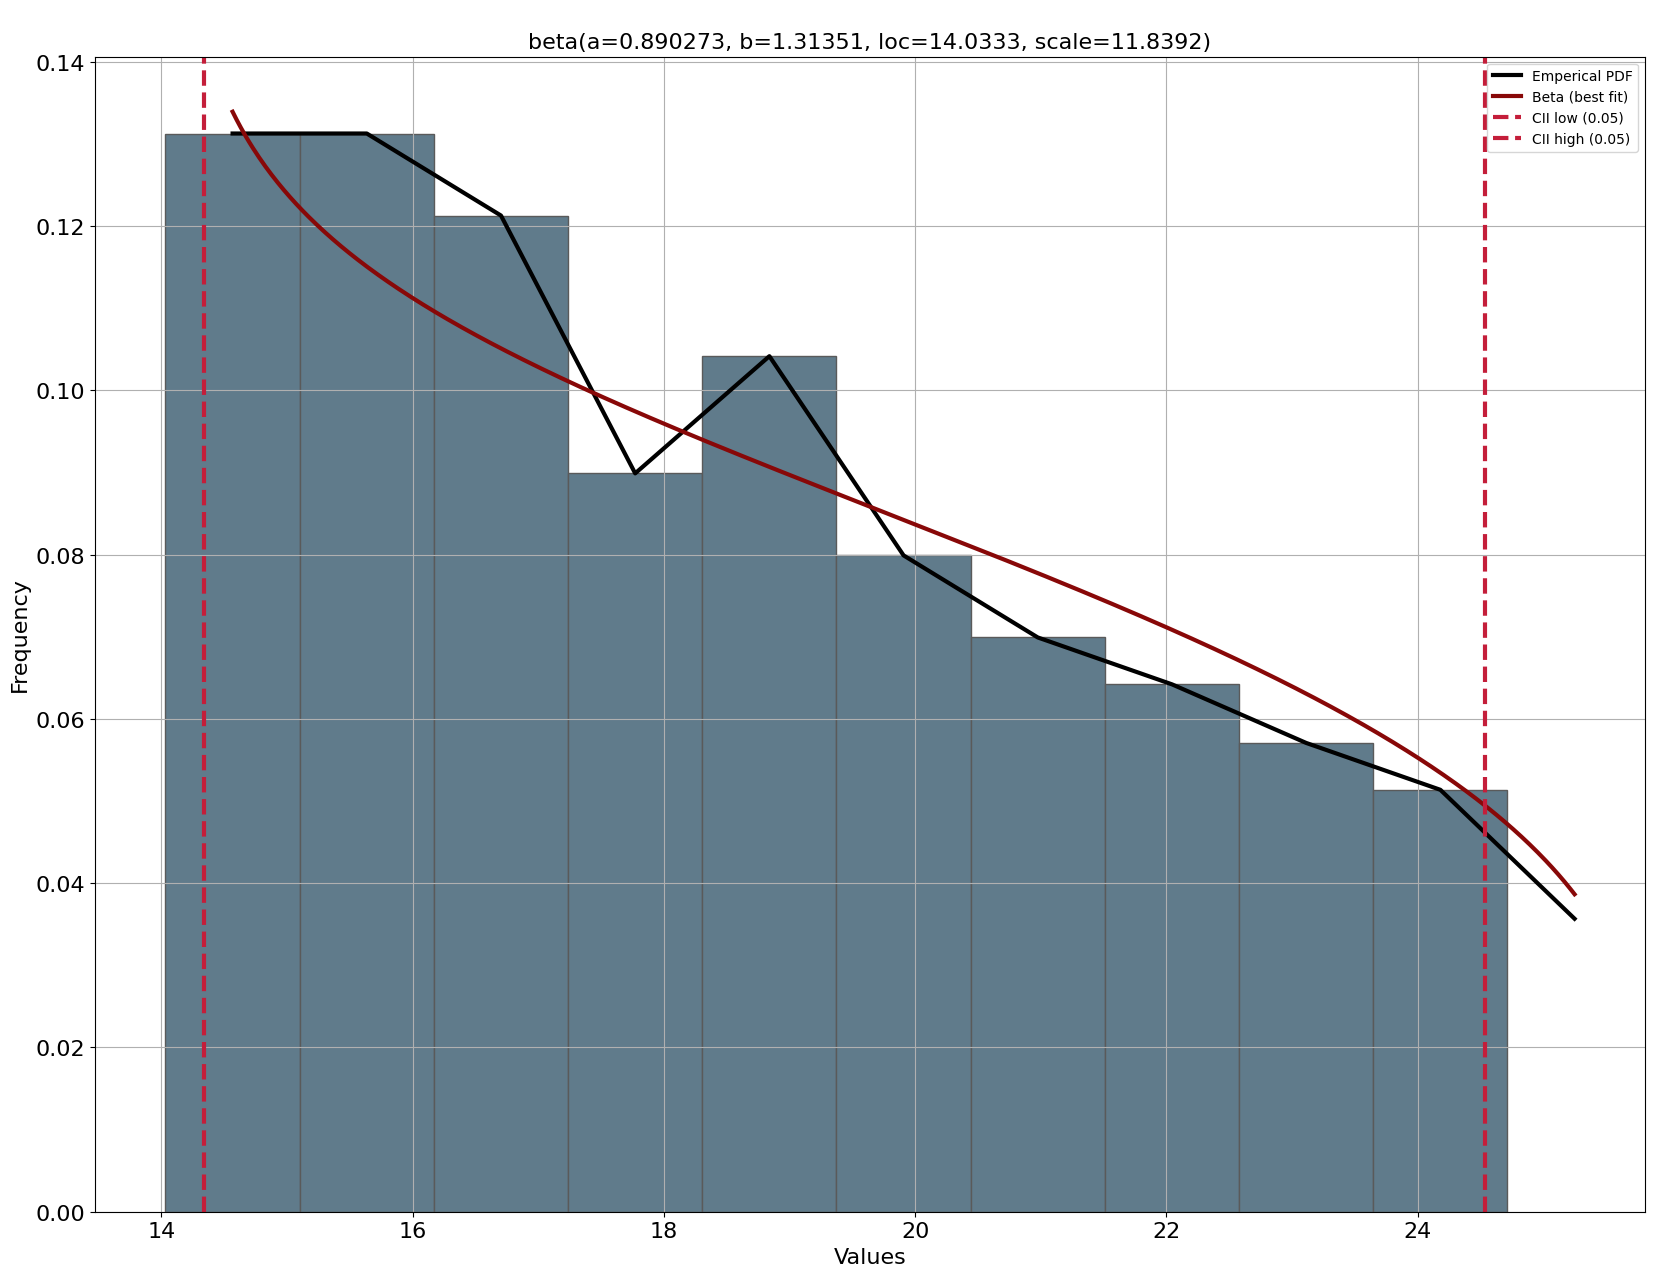

In [312]:
fit(1,5)

In [318]:
base


,index,Mes,dia,dia_mes,Cliente,TipoServ.,Servidor,Turno,Cuadrilla,min_cliente,Llegada,intervalo_1,intervalo_2,num_dia,clase,intervalo,kmeans,num_mes,tipo_serv
0,0,Abril,Miercoles,1,1,Tecnica,Juan Lopez,1,1,9.516667,1900-01-01 06:09:31,1,0,3,1,1,0,4,1
1,1,Abril,Miercoles,1,2,Cancelacion,Teresa Rodriguez,1,1,12.233333,1900-01-01 06:21:45,1,0,3,1,1,0,4,2
2,2,Abril,Miercoles,1,3,Tecnica,Luis Meza,1,1,72.183333,1900-01-01 07:33:56,2,0,3,4,2,4,4,1
3,3,Abril,Miercoles,1,4,Cancelacion,Luisa Diaz,1,1,5.100000,1900-01-01 07:39:02,2,0,3,1,2,2,4,2
4,4,Abril,Miercoles,1,5,Tecnica,Rocio Peña,1,1,11.616667,1900-01-01 07:50:39,2,0,3,1,2,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,8607,Noviembre,Viernes,30,43,Cancelacion,Luisa Diaz,1,1,13.783333,1900-01-01 13:36:08,8,0,5,1,8,0,11,2
4349,8608,Noviembre,Viernes,30,44,Otro,Rocio Peña,1,1,4.383333,1900-01-01 13:40:31,8,0,5,1,8,2,11,3
4350,8609,Noviembre,Viernes,30,45,Tecnica,Juan Lopez,1,1,2.000000,1900-01-01 13:42:31,8,0,5,1,8,2,11,1
4351,8610,Noviembre,Viernes,30,46,Cambio Plan,Teresa Rodriguez,1,1,11.016667,1900-01-01 13:53:32,8,0,5,1,8,0,11,5


In [319]:
cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla"]
for i in cosas:
  print("%%%%"*10)
  print("Para "+i)
  print("---"*10)
  print(pd.crosstab(base['kmeans'],base[i]))

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para Mes
------------------------------
Mes     Abril  Noviembre  Septiembre
kmeans                              
0         439        429         458
1          93        105          75
2         675        643         727
3         209        203         244
4          22         17          14
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para dia
------------------------------
dia     Domingo  Jueves  Lunes  Martes  Miercoles  Sabado  Viernes
kmeans                                                            
0           169     233    165     177        202     155      225
1            42      39     43      34         40      38       37
2           273     377    249     312        275     236      323
3            82     123     83      91         94      84       99
4             7       5      9       6          6      12        8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para TipoServ.
------------------------------
TipoServ.  Cambio Plan 

#Realizando Gauss para determinar kmeans, nada concluyente


In [175]:
cosas=["dia","TipoServ.","intervalo","Mes","Cuadrilla"]
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]

for t in [1,2]:
  base=arribo[(arribo['Turno']==t)]
  base=base.reset_index()
  X = base[['min_cliente','num_mes','intervalo','tipo_serv','num_dia','dia_mes','Cuadrilla']]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  df=pd.DataFrame()
  for n_components in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)

    # Obtener las etiquetas predichas
    labels = gmm.predict(X_scaled)

    # Agregar las etiquetas al DataFrame original
    df[n_components] = labels


  for k in list(df.columns):
    base['kmeans']=df[k]

    for i in base['kmeans'].unique():
      eval=base[(base['kmeans']==i)]

      for j in cosas:
        if len(eval[j].unique())>1:
          mete=(k,i)
          sorce.append(j)
          turno.append(t)
          arreglo.append(mete)
          kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
          levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
          pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
kruskal["Independencia"] = kruskal['p-unc'] <= 0.05
levene['Source']=sorce

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: div

In [176]:
for t in [1,2]:
  print("$$$$"*10)
  print("Para el turno "+str(t))
  for i in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("%%%"*10)
    print("Para grupos de "+str(i))
    print("--"*10)
    print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)&(kruskal['turno']==t)])
    print("++"*10)
    print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)&(levene['turno']==t)])
    print("--"*10)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1         H     p-unc   grupo  turno  Independencia
Kruskal        dia      4  2.831563  0.586397  (2, 0)      1          False
Kruskal  TipoServ.      4  3.487359  0.479803  (2, 0)      1          False
Kruskal        Mes      2  0.120702  0.941434  (2, 0)      1          False
Kruskal  Cuadrilla      1  1.731680  0.188196  (2, 0)      1          False
Kruskal        dia      1  1.085045  0.297572  (2, 1)      1          False
Kruskal  TipoServ.      4  8.239910  0.083175  (2, 1)      1          False
Kruskal        Mes      2  5.580851  0.061395  (2, 1)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  6.611693  1.338105e-08      False  (2, 0)      1  intervalo
levene  4.424761  7.332107e-05      False  (2, 1)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%%%%%